In [2]:
import numpy as np
import tifffile

import os

from scripts.config_model import save_experiment_config, tree
from scripts.sample_db import SampleDB
from scripts.utils.image_utils import load_tiff_as_hyperstack, save_array_as_hyperstack_tiff


In [106]:
# Step 1: Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)
print(sample_db)

SampleDB(sample_ids=['20220426_RM0008_130hpf_fP1_f3', '20220118_RM0012_124hpf_fP8_f2', '20220427_RM0008_126hpf_fP3_f3'])


In [107]:
# Step 2: Load experiment configuration
sample_id = '20220426_RM0008_130hpf_fP1_f3'
exp = sample_db.get_sample(sample_id)

In [108]:
# Step 3: Making shortcuts of sample parameters/information
sample = exp.sample
root_path = exp.paths.root_path
trials_path = exp.paths.trials_path
anatomy_path = exp.paths.anatomy_path
em_path = exp.paths.em_path
n_planes = exp.params_lm.n_planes
n_frames = exp.params_lm.n_frames
n_slices = exp.params_lm.lm_stack_range
doubling = 2 if exp.params_lm.doubling else 1

# Calculating number of frames per trial 
n_frames_trial = n_frames // n_planes
exp.params_lm["n_frames_trial"] = n_frames_trial

# Getting paths of the trial acquisitions
raw_trial_paths = os.listdir(os.path.join(trials_path, "raw"))
n_trials = len(raw_trial_paths)
exp.params_lm["n_trials"] = n_trials
ignore_until_frame = exp.params_lm.shutter_delay_frames  # edit if you want to avoid summing out motor movements at the beginning of acquisition

# Define the path for the preprocessed folder
processed_folder = os.path.join(trials_path, "processed")
os.makedirs(processed_folder, exist_ok=True)

ref_images_path = os.path.join(processed_folder, f"sum_raw_trials_{sample.id}.tif")

In [109]:
# Upload images 
lm_planes =tifffile.imread(ref_images_path)
lm_plane = lm_planes[6,-1]
print(lm_planes.shape)
lm_stack = os.listdir(os.path.join(exp.paths.anatomy_path, "processed"))
print(lm_stack)
lm_stack_raw = load_tiff_as_hyperstack(os.path.join(exp.paths.anatomy_path, "raw", "20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif"),n_channels=2)[0]
print(lm_stack_raw.shape)
lm_stack_processed = tifffile.imread(os.path.join(exp.paths.anatomy_path,"processed","grayscale_flipped_upsampled_20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif"))

em_stack_raw = tifffile.imread(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\CLEM_Analyses\CLEM_20220426_RM0008_130hpf_fP1_f3\fine_aligned_downsampled_4_em_stack.tiff")

em_stack_processed = tifffile.imread(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\CLEM_Analyses\CLEM_20220426_RM0008_130hpf_fP1_f3\bigwarp_alignment\fine_aligned_downsampled_4_em_stack_cropped_woResin_rough_rotated_to_LM.tif")


(8, 24, 256, 512)
['Composite_upsampled_denoisedGF_rawRF.tif', 'grayscale_flipped_upsampled_20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif', 'resampled_flipped_20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif', 'rgb_flipped_upsampled_20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif', 'rgb_flipped_upsampled_RF_inverted_GF.tif', 'upsampled_20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_-1.tif']
\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\anatomy\raw\20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif loaded.
(150, 512, 512)


In [110]:
# Load masks 

lm_planes_masks = tifffile.imread(os.path.join(trials_path,"masks","masks_20220426_RM0008_130hpf_fP1_f3_params_cp_-1-ft_0.4-st_0.01-resample_True_augment=False.tif"))
print(lm_planes_masks.shape)

lm_plane_mask = lm_planes_masks[6,-1]

em_stack_processed_mask = tifffile.imread(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\CLEM_Analyses\CLEM_20220426_RM0008_130hpf_fP1_f3\bigwarp_alignment\em_mask.tif")

print(em_stack_processed_mask.shape)

(8, 24, 256, 512)
(996, 288, 1129)


In [111]:
# Get centroids
from skimage.measure import regionprops, label
print(lm_plane_mask.shape)

lm_plane_props = regionprops(label(lm_plane_mask))
lm_plane_centroids =  np.array([prop.centroid for prop in lm_plane_props])

em_stack_processed_props = regionprops(em_stack_processed_mask)
em_stack_processed_centroids =  np.array([prop.centroid for prop in em_stack_processed_props])


(256, 512)


In [112]:
# Visualize
import napari

viewer = napari.Viewer()
viewer.add_image(lm_plane)
viewer.add_labels(label(lm_plane_mask))
viewer.add_points(lm_plane_centroids)

viewer.add_image(lm_stack_raw)
viewer.add_image(lm_stack_processed)

viewer.add_image(em_stack_raw)
viewer.add_image(em_stack_processed)
viewer.add_labels(em_stack_processed_mask)
viewer.add_points(em_stack_processed_centroids)


2024-07-18 11:05:18,106 - WARNING - DirectWrite: CreateFontFaceFromHDC() failed (Indicates an error in an input file such as a font file.) for QFontDef(Family="", pointsize=12, pixelsize=16, styleHint=5, weight=50, stretch=100, hintingPreference=0) LOGFONT("MS Sans Serif", lfWidth=0, lfHeight=-16) dpi=96
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Points layer 'em_stack_processed_centroids' at 0x1f6e9c81300>

In [113]:
# Initiate LUT with lm_plane centroids
import pandas

lut = pandas.DataFrame()
lut["lm_plane_zyx"] = lm_plane_centroids.tolist()
lut.head()

,lm_plane_zyx
0,"[2.7358490566037736, 195.88679245283018]"
1,"[5.515873015873016, 223.34920634920636]"
2,"[8.276923076923078, 174.77692307692308]"
3,"[9.479166666666666, 126.03125]"
4,"[13.940944881889763, 295.8582677165354]"


In [114]:
import alignment.image_alignment as ia

from alignment.image_processing import slice_into_uniform_tiles
import importlib
importlib.reload(ia)

<module 'alignment.image_alignment' from 'D:\\montruth\\PycharmProjects\\samplePy\\alignment\\image_alignment.py'>

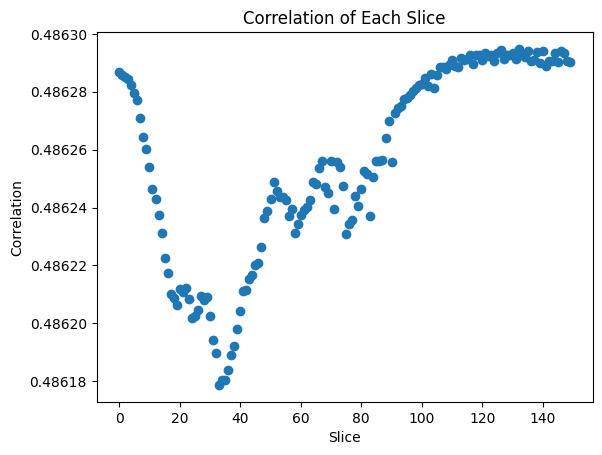

In [115]:
# Create transformation matrix lm_plane --> lm_stack
max_corr_coarse, max_position_coarse, all_correlations_coarse = ia.rough_alignment_plane_in_stack(lm_plane, lm_stack_raw, plot_all_correlations= True)

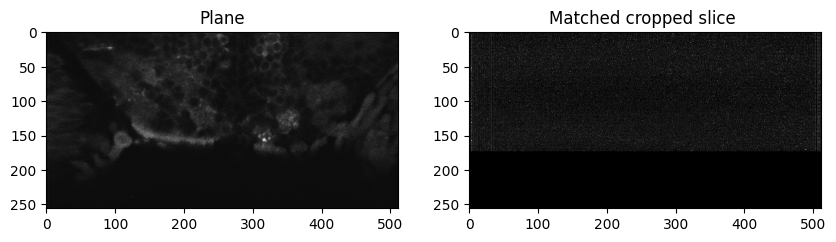

In [116]:
ia.plot_matched_plane_and_cropped_slice(lm_stack_raw,lm_plane, max_position_coarse)

In [117]:
print(max_position_coarse[0])
z_range = 50
half_z_range = z_range // 2
# Ensure min_z_range is not less than 0 and max_z_range does not exceed stack.shape[0]
min_z_range = max(0, max_position_coarse[0] - half_z_range)
max_z_range = min(lm_stack_raw.shape[0], max_position_coarse[0] + half_z_range)

z_crop = range(min_z_range, max_z_range)

print(z_crop[0], z_crop[-1])

132
107 149


Original image size: 256x512
Tile size: 64x128
Adjusted image size for perfect slicing: 256x512
Number of tiles: 16


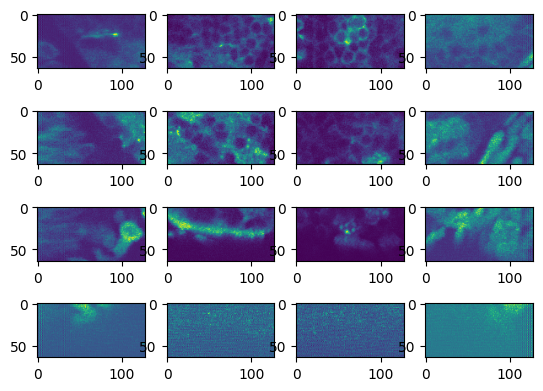

In [118]:
#Define stack and planes to match 
nx, ny = (4, 4)
tiles, tile_size, adj_image_size = slice_into_uniform_tiles(lm_plane, nx, ny, plot=True)
tiles_filter = np.array([[1, 1, 1, 1],
                         [1, 1, 1, 1],
                        [0, 1, 1, 0],
                        [0, 0, 0, 0]])

In [119]:
%%time
best_plane_matrix, all_correlations_matrix = ia.find_best_planes(tiles, lm_stack_raw, tiles_filter, z_range=[z_crop[0], z_crop[-1]])

CPU times: total: 38.9 s
Wall time: 39.3 s


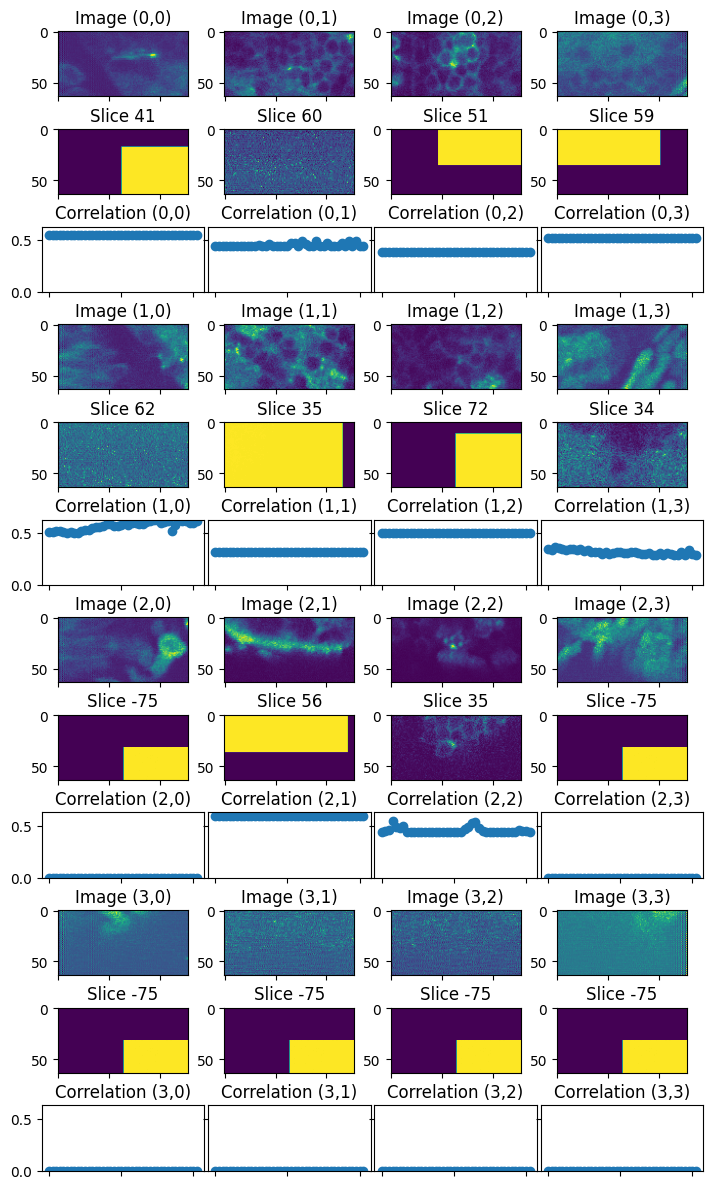

CPU times: total: 7.84 s
Wall time: 7.98 s


In [120]:
%%time
ia.plot_image_correlation(tiles, lm_stack_raw, best_plane_matrix, all_correlations_matrix)

(111, 3)
(array([0, 1, 2, 3, 5, 6], dtype=int64),)
[[116  14   2]
 [135 478 190]
 [126 508  18]
 [134 508 475]
 [137 471 253]
 [110 123 460]
 [147  20   1]
 [109  41 276]
 [  0   0   0]
 [131 507 455]
 [110 292 311]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]]
transformed_source [[111.6385279  101.00862635  16.28360148]
 [121.55811007 228.535934   118.62397424]
 [131.47769224 356.06324165 220.96434701]
 [141.39727441 483.5905493  323.30471978]
 [126.00440661 177.13717052 182.24149236]
 [135.92398878 304.66447818 284.58186513]]
[[   4.3614721   -87.00862635  -14.28360148]
 [  13.44188993  249.464066     71.37602576]
 [  -5.47769224  151.93675835 -202.96434701]
 [  -7.39727441   24.4094507   151.69528022]
 [ -16.00440661  -54.13717052  277.75850764]
 [  11.07601122 -284.66447818 -283.58186513]]


RuntimeError: invalid shape for coordinate array

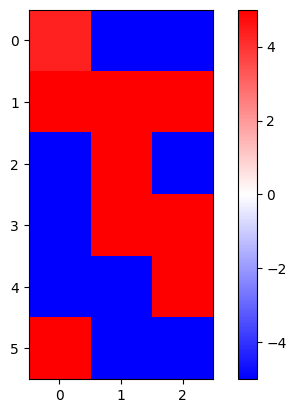

In [121]:
from skimage.transform import SimilarityTransform
from scipy import ndimage
from matplotlib import pyplot as plt

lm_plane_centroids_3d = np.hstack((np.zeros(shape=(lm_plane_centroids.shape[0],1)), lm_plane_centroids))
print(lm_plane_centroids_3d.shape)

filter_matrix= np.array([[1, 1, 1, 1],
                      [0, 1, 1, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0]])
points_filter = np.where(filter_matrix.flatten()==1)
print(points_filter)

# Create registration model  
# lm alignment points
lm_stack_points = np.array([best_plane_matrix[i,j] for i in range(nx) for j in range(ny) ])
print(lm_stack_points)


x = np.arange(tile_size[1]//2, adj_image_size[1], tile_size[1])
y = np.arange(tile_size[0]//2, adj_image_size[0], tile_size[0])
xv, yv = np.meshgrid(x, y)

lm_plane_points = np.array([(0, yv[i,j], xv[i,j])
                            for i in range(ny) for j in range(nx)])

source = lm_plane_points[points_filter]
target = lm_stack_points[points_filter]

# Calculate the transformation
tform = SimilarityTransform()
tform.estimate(source, target)

# Apply the transformation to a new set of points
transformed_source = tform(source)
print(f"transformed_source",transformed_source)
#print("Transformation matrix:")
#print(tform.params)

print(target-transformed_source)
plt.imshow(target-transformed_source, cmap="bwr", vmin = -5, vmax=5)
plt.colorbar()

# Apply transformation to lm plane centroids
transformed_lm_plane_centroids = tform(lm_plane_centroids_3d)

# Find overlay of em warped masks and transformed_lm_plane_centroids
labels_at_coords = ndimage.map_coordinates(
        em_stack_processed_centroids, np.transpose(list(transformed_lm_plane_centroids)), order=0
        )
print(f"Found {np.unique(labels_at_coords[labels_at_coords>0]).shape[0]} from {transformed_lm_plane_centroids.shape[0]} centroids ")

# Filter mask of em warped
filtered_em_mask = np.isin(em_stack_processed_centroids, list(np.unique(labels_at_coords[labels_at_coords>0])))